In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import pytorch_lightning as pl
from torchvision.models import efficientnet_b1
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule, Trainer
from torchmetrics.classification import Accuracy


In [ ]:
class Args():
    def __init__(self):
        self.output_dir = 'pt-l-checkpoints'
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.per_gpu_train_batch_size = 64
        self.per_gpu_eval_batch_size = 64
        self.learning_rate = 1e-3

        if torch.cuda.is_available():
            num_devices = torch.cuda.device_count()
        else:
            num_devices = 1

        self.train_batch_size = self.per_gpu_train_batch_size * num_devices
        self.eval_batch_size = self.per_gpu_eval_batch_size * num_devices


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

In [ ]:
args = Args()

data_path = '/kaggle/input/celeba-500my/celebA_train_500'
anno_path = os.path.join(data_path, 'celebA_anno.txt')
split_path = os.path.join(data_path, 'celebA_train_split.txt')
img_folder = os.path.join(data_path, 'celebA_imgs')

assert os.path.exists(anno_path), f"Annotation file not found at {anno_path}"
assert os.path.exists(split_path), f"Split file not found at {split_path}"
assert os.path.isdir(img_folder), f"Image folder not found at {img_folder}"

annotations = pd.read_csv(anno_path, sep=' ', header=None, names=['img_id', 'attribute'])
splits = pd.read_csv(split_path, sep=' ', header=None, names=['img_id', 'split'])

print("Annotations head:", annotations.head())
print("Splits head:", splits.head())
print("Number of images:", len(os.listdir(img_folder)))

data = pd.merge(annotations, splits, on='img_id')

def crop_image(img):
    return img.crop((45, 77, img.width - 50, img.height - 41))

transform = transforms.Compose([
    transforms.Lambda(crop_image),
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor()
])

class CelebADataset(Dataset):
    def __init__(self, img_folder, data, transform=None):
        self.img_folder = img_folder
        self.data = data
        self.transform = transform
        self.data = self.data[self.data['img_id'].apply(lambda x: os.path.exists(os.path.join(self.img_folder, x)))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]
        img_path = os.path.join(self.img_folder, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = int(self.data.iloc[idx, 1])
        return image, label

train_data = data[data['split'] == 0]
val_data = data[data['split'] == 1]
test_data = data[data['split'] == 2]

print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_data)}")

train_dataset = CelebADataset(img_folder, train_data, transform=transform)
val_dataset = CelebADataset(img_folder, val_data, transform=transform)
test_dataset = CelebADataset(img_folder, test_data, transform=transform)

print(f"Train dataset length: {len(train_dataset)}, Validation dataset length: {len(val_dataset)}, Test dataset length: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=args.eval_batch_size, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=args.eval_batch_size, num_workers=1)


Annotations head:        img_id  attribute
0  000001.jpg          0
1  000404.jpg          0
2  003415.jpg          0
3  004390.jpg          0
4  018062.jpg          0
Splits head:        img_id  split
0  000001.jpg      0
1  000404.jpg      0
2  003415.jpg      0
3  004390.jpg      0
4  018062.jpg      0
Number of images: 23948
Train samples: 8544, Validation samples: 1878, Test samples: 1589
Train dataset length: 8544, Validation dataset length: 1878, Test dataset length: 1589


In [ ]:
class CelebADataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform

    def setup(self, stage=None):
        anno_path = os.path.join(self.data_dir, 'celebA_anno.txt')
        annotations = pd.read_csv(anno_path, sep=' ', header=None, names=['img_id', 'attribute'])

        split_path = os.path.join(self.data_dir, 'celebA_train_split.txt')
        splits = pd.read_csv(split_path, sep=' ', header=None, names=['img_id', 'split'])

        data = pd.merge(annotations, splits, on='img_id')

        self.train_data = data[data['split'] == 0]
        self.val_data = data[data['split'] == 1]
        self.test_data = data[data['split'] == 2]

        self.train_dataset = CelebADataset(os.path.join(self.data_dir, 'celebA_imgs'), self.train_data, transform=self.transform)
        self.val_dataset = CelebADataset(os.path.join(self.data_dir, 'celebA_imgs'), self.val_data, transform=self.transform)
        self.test_dataset = CelebADataset(os.path.join(self.data_dir, 'celebA_imgs'), self.test_data, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=1)

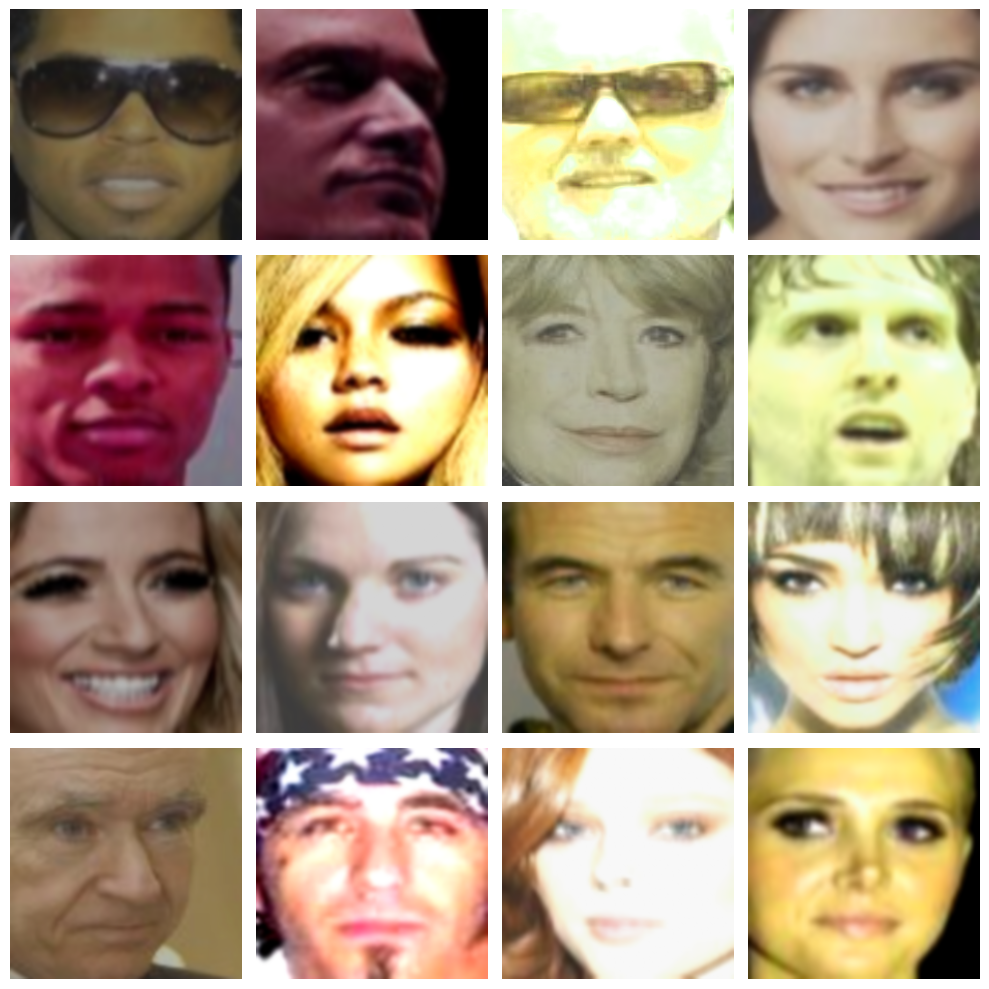

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Проверим что у нас выводит датасет
def show_random_images(data_loader, num_images=16):
    images, labels = next(iter(data_loader))
    images = images.numpy()

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for img, ax in zip(images[:num_images], axes):
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


show_random_images(train_loader)


In [ ]:
if not os.path.isdir(args.output_dir):
    os.mkdir(args.output_dir)

In [ ]:
'''
Решил для себя попробовать поработать с pytorch-lighting, ранее не использовал.
Создаем базовый класс, для более удобной работы.
'''
class BaseModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        backbone = efficientnet_b1(weights="DEFAULT")
        num_filters = backbone.classifier[1].in_features

        # Извлекаем слои
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # Морозим
        for param in self.feature_extractor.parameters():
            param.requires_grad = True


        self.fc1 = nn.Linear(num_filters, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.classifier = nn.Linear(256, 500)

        self.train_accuracy = Accuracy(task="multiclass", num_classes=500)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=500)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=500)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return x

    def extract_embeddings(self, x):
        return self.forward(x)

    def classify(self, x):
        embeddings = self.extract_embeddings(x)
        logits = self.classifier(embeddings)
        return logits
    def classify1(self, x):

        logits = self.classifier(x)
        return logits


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.05)
        return [optimizer], [scheduler]

In [ ]:

class ImagenetEffCE(BaseModel):
    def __init__(self):
        super().__init__()
        self.train_accuracies = []
        self.val_accuracies = []
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.classify(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_accuracy(y_hat, y)
        self.train_accuracies.append(acc.item())
        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('train_acc', acc, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.classify(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_accuracy(y_hat, y)
        self.val_accuracies.append(acc.item())
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_acc', acc, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.classify(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.test_accuracy(y_hat, y)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        self.log('test_acc', acc, prog_bar=True, logger=True)
        return loss

In [ ]:
class ArcFaceLoss(nn.Module):
    def __init__(self, scale=12.0, margin=0.10, num_classes=500, embedding_size=256): # Путем тестов, определил что в моем случае такие параметры Scale Margin работают нилучишм образом
        super(ArcFaceLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        weights = F.normalize(self.weight)

        logits = torch.matmul(embeddings, weights.t())

        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.margin)

        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        output = (one_hot * target_logits) + ((1.0 - one_hot) * logits)
        output *= self.scale

        loss = F.cross_entropy(output, labels)

        return loss, output

class ImagenetEffArcFace(BaseModel):
    def __init__(self):
        super().__init__()
        self.arcface_loss = ArcFaceLoss(num_classes=500, embedding_size=256)
        self.train_accuracies = []
        self.val_accuracies = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        embeddings = self.extract_embeddings(x)
        loss, logits = self.arcface_loss(embeddings, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.train_accuracy(preds, y)
        self.train_accuracies.append(acc.item())

        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('train_acc', acc, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        embeddings = self.extract_embeddings(x)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        loss, logits = self.arcface_loss(embeddings, y)
        val_loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        val_acc = self.val_accuracy(preds, y)
        self.val_accuracies.append(val_acc.item())

        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_acc', val_acc, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        embeddings = self.extract_embeddings(x)
        loss, logits = self.arcface_loss(embeddings, y)

        preds = torch.argmax(logits, dim=1)
        acc = self.test_accuracy(preds, y)

        self.log('test_loss', loss, prog_bar=True, logger=True)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        return loss

In [ ]:
# Приступаем к обучению и тестированию

In [ ]:
if __name__ == "__main__":

    # Effnet + CE loss

    data_module = CelebADataModule(data_dir=data_path, batch_size=args.train_batch_size)
    model_ce = ImagenetEffCE()
    trainer = Trainer(max_epochs=26, log_every_n_steps=1)
    trainer.fit(model_ce, datamodule=data_module)

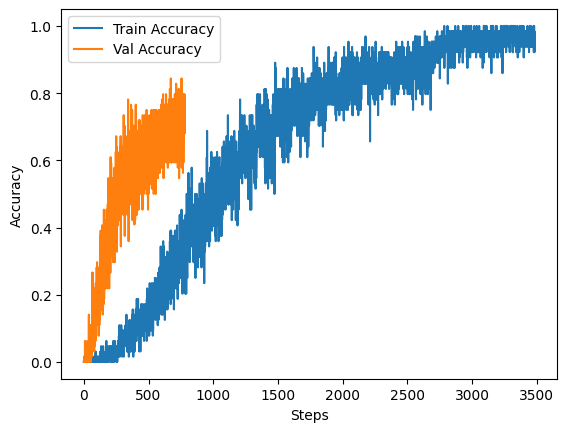

In [ ]:
plt.plot(model_ce.train_accuracies, label='Train Accuracy')
plt.plot(model_ce.val_accuracies, label='Val Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Effnet + CE loss

trainer.test(model_ce, datamodule=data_module)


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7073631286621094     │
│         test_loss         │     1.737633228302002     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'test_loss': 1.737633228302002, 'test_acc': 0.7073631286621094}]

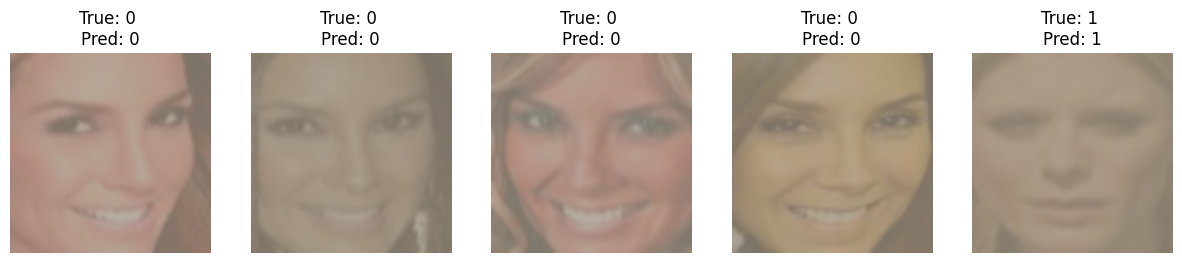

In [ ]:
test_loader = data_module.test_dataloader()

# Get a batch of test data
test_images, test_labels = next(iter(test_loader))

# Get predictions
model_ce.eval()
with torch.no_grad():
    test_outputs = model_ce.classify(test_images)
    _, preds = torch.max(test_outputs, 1)

# Visualizing 5 test images with their predictions and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes[:5]):
    img = test_images[i].permute(1, 2, 0)  # Change shape to (H, W, C)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
    img = img.clip(0, 1)
    ax.imshow(img)
    ax.set_title(f'True: {test_labels[i].item()} \nPred: {preds[i].item()}')
    ax.axis('off')

plt.show()

In [ ]:
# Effnet + Arkface loss

data_module = CelebADataModule(data_dir=data_path, batch_size=args.train_batch_size)
model_arcface = ImagenetEffArcFace()
trainer = Trainer(max_epochs=25, log_every_n_steps=1)
trainer.fit(model_arcface, datamodule=data_module)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

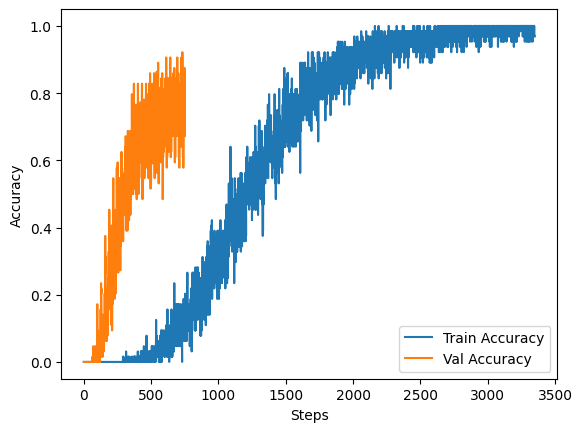

In [ ]:
# Plotting Accuracy Graphs
plt.plot(model_arcface.train_accuracies, label='Train Accuracy')
plt.plot(model_arcface.val_accuracies, label='Val Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Effnet + Arkface loss
trainer.test(model_arcface, datamodule=data_module)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7482693791389465     │
│         test_loss         │    1.3934412002563477     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'test_loss': 1.3934412002563477, 'test_acc': 0.7482693791389465}]

In [ ]:
checkpoint_path = "model_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

# Identificaton rate metric (TPR@FPR)



In [ ]:
# Просто скопировал код из ноутбука


from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('/kaggle/input/celeba-ir-my/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('/kaggle/input/celeba-ir-my/celebA_ir/celebA_distractors')

In [ ]:
class IRMCelebADataset(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        self.img_dir = img_dir
        self.img_names = img_names
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

transf = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor()
])

In [ ]:
class CelebQ_D(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, transf, query_img_names, distractors_img_names):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transf
        self.query_img_names = query_img_names
        self.distractors_img_names = distractors_img_names

    def setup(self, stage=None):
        self.query_dataset = IRMCelebADataset(
            os.path.join(self.data_dir, 'celebA_query'),
            img_names=self.query_img_names,
            transform=self.transform
        )
        self.distractors_dataset = IRMCelebADataset(
            os.path.join(self.data_dir, 'celebA_distractors'),
            img_names=self.distractors_img_names,
            transform=self.transform
        )

    def query_dataloader(self):
        return DataLoader(self.query_dataset, batch_size=self.batch_size, shuffle=False, num_workers=3)

    def distractors_dataloader(self):
        return DataLoader(self.distractors_dataset, batch_size=self.batch_size,shuffle=False, num_workers=3)

In [ ]:
data_dir = '/kaggle/input/celeba-ir-my/celebA_ir'
batch_size = 32
celebq_d = CelebQ_D(
        data_dir=data_dir,
        batch_size=batch_size,
        transf=transf,
        query_img_names=query_img_names,
        distractors_img_names=distractors_img_names
    )
celebq_d.setup()

query_loader = celebq_d.query_dataloader()
distractors_loader = celebq_d.distractors_dataloader()


def compute_embeddings(model, images_loader):
    '''
    Compute embeddings from the trained model for list of images.

    Parameters:
        model: trained nn model that takes images and outputs embeddings
        images_loader: DataLoader for images to compute embeddings for

    Output:
        list: list of model embeddings. Each embedding corresponds to images
              names from images_loader
    '''


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()


    embeddings = []

    with torch.no_grad():
        for batch in images_loader:
            batch = batch.to(device)
            batch_embeddings = model.extract_embeddings(batch)
            batch_embeddings = batch_embeddings.view(batch_embeddings.size(0), -1)
            batch_embeddings = batch_embeddings.cpu().numpy()
            embeddings.extend(batch_embeddings)

    return embeddings
    raise NotImplementedError

In [ ]:
# Найдем эмбеддинги
query_embeddings = compute_embeddings(model_ce, query_loader)
distractors_embeddings = compute_embeddings(model_ce, distractors_loader)

In [ ]:
import torch
import torch.nn.functional as F

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to the same people from query list
    '''

    img_name_to_embedding = {name: embedding for name, embedding in zip(query_img_names, query_embeddings)}

    similarities = []


    for class_images in query_dict.values():

        for i in range(len(class_images)):
            for j in range(i + 1, len(class_images)):
                img_name_1 = class_images[i]
                img_name_2 = class_images[j]


                embedding_1 = img_name_to_embedding[img_name_1]
                embedding_2 = img_name_to_embedding[img_name_2]


                embedding_1 = torch.tensor(embedding_1)
                embedding_2 = torch.tensor(embedding_2)


                cosine_similarity = F.cosine_similarity(embedding_1.unsqueeze(0), embedding_2.unsqueeze(0)).item()
                similarities.append(cosine_similarity)

    return similarities

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to different people from query list
    '''

    img_name_to_embedding = {name: embedding for name, embedding in zip(query_img_names, query_embeddings)}

    similarities = []


    classes = list(query_dict.keys())
    all_images = sum(query_dict.values(), [])


    for i in range(len(classes)):
        class_i_images = query_dict[classes[i]]
        for img_name_1 in class_i_images:
            embedding_1 = torch.tensor(img_name_to_embedding[img_name_1])


            for j in range(i + 1, len(classes)):
                class_j_images = query_dict[classes[j]]
                for img_name_2 in class_j_images:
                    embedding_2 = torch.tensor(img_name_to_embedding[img_name_2])

                    # Вычисляем косинусное сходство
                    cosine_similarity = F.cosine_similarity(embedding_1.unsqueeze(0), embedding_2.unsqueeze(0)).item()
                    similarities.append(cosine_similarity)

    return similarities

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    '''
    similarities = []


    query_embeddings = [torch.tensor(embedding) for embedding in query_embeddings]
    distractors_embeddings = [torch.tensor(embedding) for embedding in distractors_embeddings]


    for query_embedding in query_embeddings:
        for distractor_embedding in distractors_embeddings:

            cosine_similarity = F.cosine_similarity(query_embedding.unsqueeze(0), distractor_embedding.unsqueeze(0)).item()
            similarities.append(cosine_similarity)

    return similarities


In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

## Тесты

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

In [ ]:
import math
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr):
    false_pairs = cosine_query_neg + cosine_query_distractors
    false_pairs_len = len(false_pairs)

    n_fpr = math.ceil(len(false_pairs) * fpr)

    false_pairs_sorted = sorted(false_pairs)

    threshold = false_pairs_sorted[(1-n_fpr)-1]



    cosine_query_pos = np.array(cosine_query_pos)

    true_positives = np.sum(cosine_query_pos > threshold)
    total_positives = len(cosine_query_pos)
    tpr = true_positives / total_positives
    return threshold, tpr

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

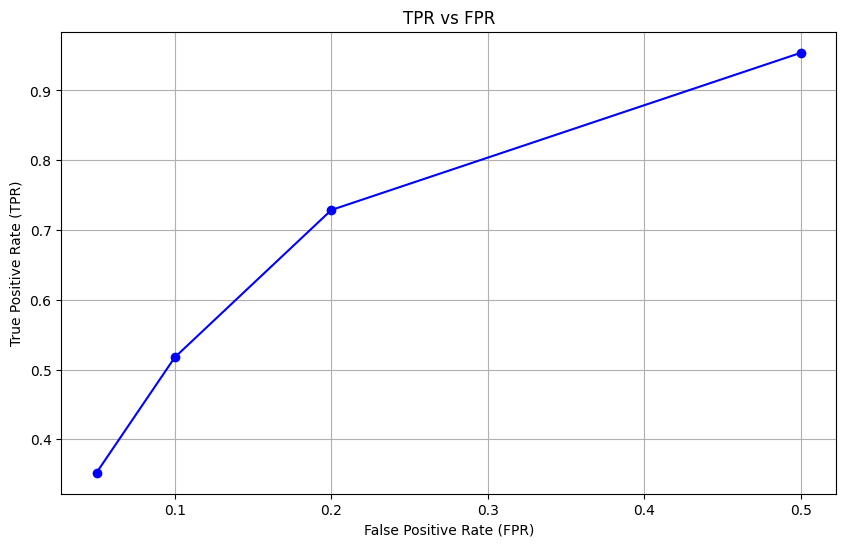

In [ ]:
# Запуск на реальных данных
fpr = [0.5, 0.2, 0.1, 0.05]
tpr = []

for f in fpr:
  _, y = compute_ir(cosine_query_pos, cosine_query_neg,
                    cosine_query_distractors, fpr=f)
  tpr.append(y)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='o', linestyle='-', color='b')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR vs FPR')
plt.grid(True)
plt.show()

In [1]:
!pip install dlib opencv-python
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, Image



In [2]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-07-13 20:45:46--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.5MB/s    in 3.3s    

2024-07-13 20:45:50 (18.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
# Проверка наличия файлов в директории
dataset_path = 'fer2013/test'
print(os.listdir(dataset_path))

['sad', 'disgust', 'surprise', 'angry', 'fear', 'neutral', 'happy']


Saving photo_2024-05-09_14-41-50.jpg to photo_2024-05-09_14-41-50.jpg
Saving Screenshot_31.png to Screenshot_31.png


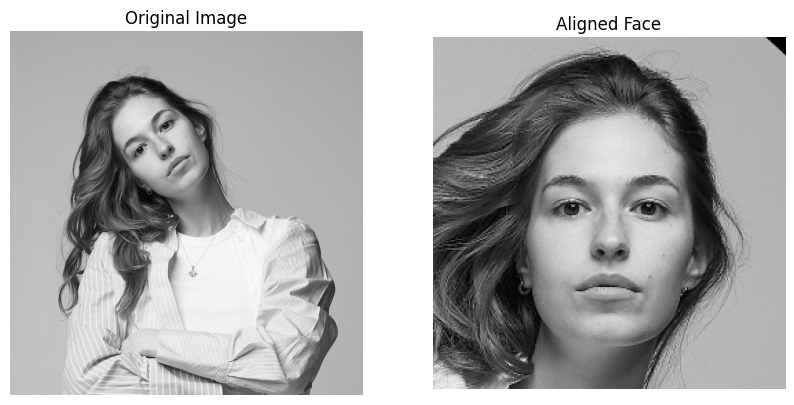

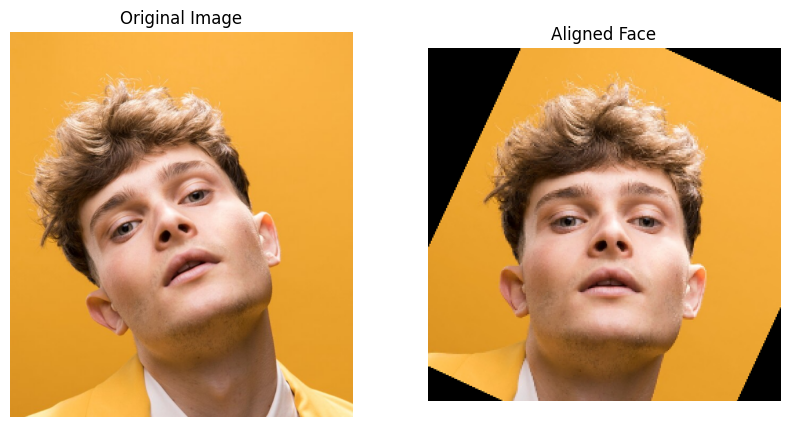

In [3]:
import cv2
import dlib
from google.colab import files


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def align_face(image_path):

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    faces = detector(gray)

    if len(faces) == 0:
        print("Лицо не найдено.")
        return None, None


    face = faces[0]


    landmarks = predictor(gray, face)


    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)


    eyes_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)


    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dY, dX))


    desired_right_eye_x = 1.0 - 0.35
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desired_dist = (desired_right_eye_x - 0.35) * 256
    scale = desired_dist / dist


    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    tX = 128
    tY = 128
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])


    output = cv2.warpAffine(image, M, (256, 256), flags=cv2.INTER_CUBIC)

    return image, output


uploaded = files.upload()


for filename in uploaded.keys():
    original_image, aligned_face = align_face(filename)
    if aligned_face is not None:

        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        aligned_face_rgb = cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(original_image_rgb)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(aligned_face_rgb)
        plt.title('Aligned Face')
        plt.axis('off')

        plt.show()
